# Model experimentation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
#from hybrid_regressor import CombinedRegressor, LinearBoost

import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
from mizani.breaks import date_breaks
from plotnine import *
import lightgbm as lgbm
import xgboost as xgb

In [2]:
reservoir_hourly = pd.read_csv('../data/processed/reservoir_data_hourly.csv', parse_dates=['timestamp'])
reservoir_hourly = reservoir_hourly.set_index('timestamp')
reservoir_hourly

,nombre_embalse,cota
timestamp,,
2022-01-01 04:00:00+00:00,ANGOSTURA,316.42
2022-01-01 05:00:00+00:00,ANGOSTURA,316.42
2022-01-01 06:00:00+00:00,ANGOSTURA,316.44
2022-01-01 07:00:00+00:00,ANGOSTURA,316.45
2022-01-01 08:00:00+00:00,ANGOSTURA,316.46
...,...,...
2023-01-28 11:00:00+00:00,RAPEL,103.72
2023-01-28 12:00:00+00:00,RAPEL,103.72
2023-01-28 13:00:00+00:00,RAPEL,103.72


## Anomaly detection, removal and imputation

In [3]:
def detect_outliers(df, value_col, period = None, robust = True):
    serie = df[value_col]
    res = STL(serie, period = period, robust = robust).fit()
    resid = res.resid
    q1 = resid.quantile(0.25)
    q3 = resid.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (3*iqr)
    upper = q3 + (3*iqr)

    anomalies = serie[(resid < lower) | (resid >= upper)]
    df = df.assign(anomaly = np.where(df[value_col].index.isin(anomalies.index), 1, 0))
    df["value_corrected"] = np.where(df["anomaly"] == True, np.NaN, df[value_col])
    df.interpolate(method = "linear", inplace=True)
    df["value_corrected"] = np.where(df["value_corrected"].isna(), df[value_col], df["value_corrected"])
    return df

In [4]:
reservoir_list = reservoir_hourly["nombre_embalse"].unique()

emb_df_list = list()
emb_df_anomalies_list = list()
for emb in reservoir_list:
    emb_df = reservoir_hourly[reservoir_hourly["nombre_embalse"] == emb]
    emb_df = emb_df.asfreq("H")
    emb_df = emb_df.sort_index()
    
    emb_df_sin_outliers = detect_outliers(emb_df, "cota", robust=True)
    emb_df_list.append(emb_df_sin_outliers)

In [5]:
data_cleaned = pd.concat(emb_df_list, axis = 0)
data_cleaned.head()

,nombre_embalse,cota,anomaly,value_corrected
timestamp,,,,
2022-01-01 04:00:00+00:00,ANGOSTURA,316.42,0,316.42
2022-01-01 05:00:00+00:00,ANGOSTURA,316.42,0,316.42
2022-01-01 06:00:00+00:00,ANGOSTURA,316.44,0,316.44
2022-01-01 07:00:00+00:00,ANGOSTURA,316.45,0,316.45
2022-01-01 08:00:00+00:00,ANGOSTURA,316.46,0,316.46


In [6]:
data_cleaned = data_cleaned.drop(['cota', 'anomaly'], axis=1)

In [7]:
# Validation split
val_len = 24 # one day
in_sample_df = data_cleaned.groupby("nombre_embalse", group_keys=False).apply(lambda x : x.iloc[:-val_len, :])
out_of_sample_df = data_cleaned.groupby("nombre_embalse", group_keys=False).apply(lambda x : x.iloc[-val_len:, :])

in_sample_df = in_sample_df.reset_index()
out_of_sample_df = out_of_sample_df.reset_index()

In [8]:
# Train test split
test_time = pd.Timedelta(24*7*4, unit = "H")
split_point = in_sample_df["timestamp"].max() - test_time

X_train = in_sample_df[in_sample_df["timestamp"] < split_point]
X_test = in_sample_df[in_sample_df["timestamp"] >= split_point - pd.Timedelta(24*4, unit = "H")]

y_train = in_sample_df[in_sample_df["timestamp"] < split_point][["timestamp","nombre_embalse","value_corrected"]]
y_test = in_sample_df[in_sample_df["timestamp"] >= split_point - pd.Timedelta(24*4, unit = "H")][["timestamp", "nombre_embalse", "value_corrected"]]

In [9]:
X_train = X_train.set_index(["timestamp", "nombre_embalse"])
X_test = X_test.set_index(["timestamp", "nombre_embalse"])
y_train = y_train.set_index(["timestamp", "nombre_embalse"])
y_test = y_test.set_index(["timestamp", "nombre_embalse"])

## Feature Engineering

In [10]:
# Fourier Features Class
class AddFourierFeatures(BaseEstimator, TransformerMixin):
    seconds_per_day = 24*60*60     # Daily dataset
    seconds_per_hour = 60*60       # Hourly dataset

    def __init__(self, K, periods: list, by = "day"):
        self.K = K
        self.periods = periods
        self.by = by

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        X = X.copy()
        dates = X.index
        
        for period in self.periods:
            term = self.K / period
            timestamps = dates.map(datetime.datetime.timestamp)
            ts_scaled = []

            for ts in timestamps:
                if self.by == "day":
                    x_scaled = round(ts / self.seconds_per_day)
                    ts_scaled.append(x_scaled)
                else:
                    x_scaled = round(ts / self.seconds_per_hour)
                    ts_scaled.append(x_scaled)

            X["fourier_sin"] = [np.sin(2 * np.pi * term * ts) for ts in ts_scaled]
            X["fourier_cos"] = [np.cos(2 * np.pi * term * ts) for ts in ts_scaled]

        return X

In [11]:
# Transformers
horizon = 24

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "hour",
        "day_of_month",
        "month",
        "year",
        "day_of_year",
        "week",
        "day_of_week",
        "weekend"
    ],
    drop_original = False,
    utc = True
)

cyclicf = CyclicalFeatures(
    variables=["hour", "month", "day_of_year"],
    drop_original= True
)

fourierf = AddFourierFeatures(
    K = 1,
    periods=[horizon, horizon*2],
    by = "hour"
)

lagf = LagFeatures(
    variables="value_corrected",
    periods=list(range(1,horizon+1)),
    missing_values = "ignore"
)

windf24 = WindowFeatures(
    variables="value_corrected",
    functions=["mean"],
    window=[int(horizon/2), horizon],
    freq="1H",
    missing_values="ignore"
)

imputer = DropMissingData()

drop_features = DropFeatures(features_to_drop=["value_corrected"])

In [12]:
prep_pipeline = Pipeline([
    ("datetime features", dtf),
    ("cyclical features", cyclicf),
    ("fourier features", fourierf),
    ("lag features", lagf),
    ("window features 24H", windf24),
    ("imputer", imputer),
    ("drop features", drop_features)
])

centrales = X_train.index.get_level_values(1).unique()
X_train_t_list = list()
X_test_t_list = list()
for cen in centrales:
    emb_df = X_train[X_train.index.get_level_values(1) == cen]
    emb_df = emb_df.reset_index(level=1)
    emb_df_t = prep_pipeline.fit_transform(emb_df)
    emb_df_t = emb_df_t.set_index("nombre_embalse", append=True)
    X_train_t_list.append(emb_df_t)
    
    emb_test = X_test[X_test.index.get_level_values(1) == cen]
    emb_test = emb_test.reset_index(level=1)
    emb_test_t = prep_pipeline.transform(emb_test)
    emb_test_t = emb_test_t.set_index("nombre_embalse", append=True)
    X_test_t_list.append(emb_test_t)

X_train_t = pd.concat(X_train_t_list, axis = 0)
X_test_t = pd.concat(X_test_t_list, axis = 0)

In [13]:
# Align
y_train_t = y_train.loc[X_train_t.index]
y_test_t = y_test.loc[X_test_t.index]

In [14]:
X_train_t = X_train_t.reset_index(level=1)
X_train_t["nombre_embalse"] = X_train_t["nombre_embalse"].astype("category")
X_test_t = X_test_t.reset_index(level=1)
X_test_t["nombre_embalse"] = X_test_t["nombre_embalse"].astype("category")

In [15]:
numeric_features = [var for var in X_train_t.columns if ((X_train_t[var].dtype == 'float') | (X_train_t[var].dtype == 'int')) & (var != "value_corrected")]
categorical_features = [var for var in X_train_t.columns if ((X_train_t[var].dtype == 'O') | (X_train_t[var].dtype == 'category'))]

In [16]:
categorical_features

['nombre_embalse']

In [17]:
# Transform features
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                   variables=numeric_features)

encoder = OneHotEncoder(variables=categorical_features)

transformer_pipe = Pipeline([
    ("scaler", scaler),
    ("encoder", encoder)
])

X_train_prep = transformer_pipe.fit_transform(X_train_t)
X_test_prep = transformer_pipe.transform(X_test_t)

In [18]:
X_train_prep.shape, y_train_t.shape

((104388, 51), (104388, 1))

## LGBM Linear Tree

In [19]:
model1 = lgbm.LGBMRegressor(linear_tree=True)
model1.fit(X_train_prep, y_train_t)

LGBMRegressor(linear_tree=True)

In [20]:
preds1 = model1.predict(X_test_prep)

In [21]:
results = pd.DataFrame(X_test_t.copy(), columns=X_test_t.columns)
results["preds"] = preds1
results["actual"] = y_test_t["value_corrected"].values
results = results.reset_index()
results = results[["timestamp","nombre_embalse","preds", "actual"]]
results["preds"] = results["preds"].clip(0)
results["error"] = results["actual"] - results["preds"]
results

,timestamp,nombre_embalse,preds,actual,error
0,2022-12-27 15:00:00+00:00,ANGOSTURA,316.793600,316.81,0.016400
1,2022-12-27 16:00:00+00:00,ANGOSTURA,316.816578,316.79,-0.026578
2,2022-12-27 17:00:00+00:00,ANGOSTURA,316.797285,316.78,-0.017285
3,2022-12-27 18:00:00+00:00,ANGOSTURA,316.804750,316.78,-0.024750
4,2022-12-27 19:00:00+00:00,ANGOSTURA,316.810871,316.76,-0.050871
...,...,...,...,...,...
8935,2023-01-27 11:00:00+00:00,RAPEL,103.748365,103.73,-0.018365
8936,2023-01-27 12:00:00+00:00,RAPEL,103.748446,103.73,-0.018446
8937,2023-01-27 13:00:00+00:00,RAPEL,103.748332,103.73,-0.018332
8938,2023-01-27 14:00:00+00:00,RAPEL,103.748453,103.73,-0.018453


In [22]:
def plot_model_performance(df):
    plt.figure(figsize = (8,4))
    # Histogram
    plt.subplot(1,2,1)
    plt.hist(df["error"], bins=20)
    plt.xlabel("Forecast Error")
    plt.ylabel("Density")
    
    # Real - Preds
    plt.subplot(1,2,2)
    plt.scatter(df.actual, df.preds)
    p1 = max(max(df.preds), max(df.actual))
    p2 = min(min(df.preds), min(df.actual))
    plt.plot([p1, p2], [p1, p2], 'r-')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    plt.tight_layout()

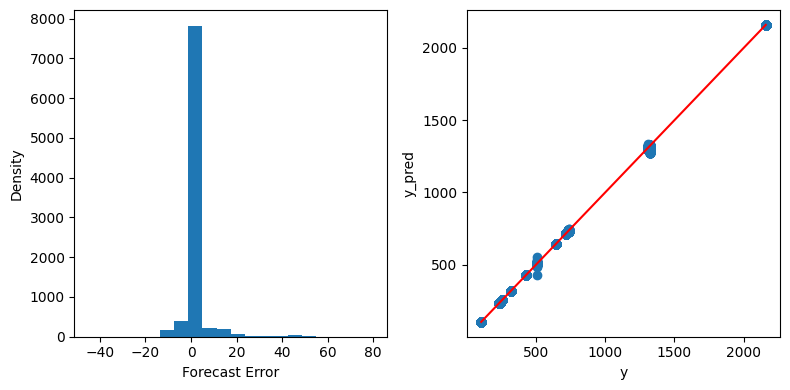

In [23]:
plot_model_performance(results)

In [24]:
def plot_forecast(df):
    final_to_plot = df.melt(
    var_name = "key",
    value_name = "value",
    value_vars = ["actual", "preds"],
    id_vars = ["timestamp", "nombre_embalse"]
    )

    final_to_plot["key"] = final_to_plot["key"].astype("category")
    
    color = ["red", "blue"]
    g = (ggplot(final_to_plot, aes(x = 'timestamp', color = "key")) +
        geom_line(aes(y = 'value')) +
        scale_color_manual(values = color) +
        facet_wrap(facets = 'nombre_embalse',
                   ncol=2, scales= 'free_y') +
        scale_x_datetime(breaks = date_breaks('3 days')) +
        labs(title = 'Generacion de embalses de pasada',
            x = '',
            y = 'Generacion',
            color = "Generacion") +
        theme(subplots_adjust= {'wspace':0.15},
              axis_text_y = element_text(size = 6),
              axis_text_x= element_text(size=6),
              plot_title = element_text(size = 12),
              axis_title_y = element_text(size=8),
              figure_size=(10,8)
              )
    )
    
    return g

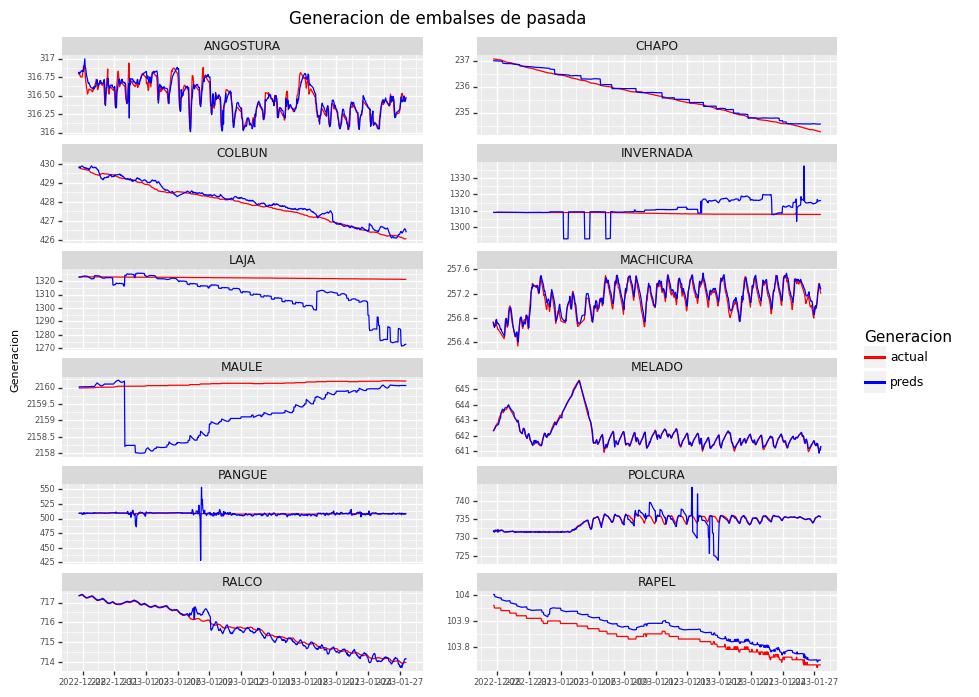

<ggplot: (8770003470871)>

In [25]:
plot_forecast(results)

In [26]:
def give_me_metrics(df):
    group_mae_test = df.groupby("nombre_embalse").apply(lambda x: mean_absolute_error(x.actual, x.preds)).to_frame("MAE")
    group_mse_test = df.groupby("nombre_embalse").apply(lambda x: mean_squared_error(x.actual, x.preds)).to_frame("MSE")
    group_rmse_test = df.groupby("nombre_embalse").apply(lambda x: mean_squared_error(x.actual, x.preds, squared=False)).to_frame("RMSE")
    group_r2_test = df.groupby("nombre_embalse").apply(lambda x: r2_score(x.actual, x.preds)).to_frame("R2")

    metric_df = group_mae_test.join(group_mse_test).join(group_rmse_test).join(group_r2_test)
    return metric_df

In [27]:
give_me_metrics(results)

,MAE,MSE,RMSE,R2
nombre_embalse,,,,
ANGOSTURA,0.054280,0.006065,0.077877,0.862791
CHAPO,0.078037,0.009720,0.098588,0.984788
COLBUN,0.160548,0.040049,0.200122,0.962699
INVERNADA,4.082684,37.619397,6.133465,-171.038988
LAJA,12.198317,305.072556,17.466326,-1031.551832
MACHICURA,0.061875,0.005234,0.072344,0.915949
MAULE,0.859352,1.169563,1.081463,-275.738727
MELADO,0.067175,0.008355,0.091407,0.990005
PANGUE,1.361829,17.012168,4.124581,-33.151826


## Combined Regressor

In [28]:
# Building Custom Model
## Credits -> 
class CombinedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 base_regressor=lgbm.LGBMRegressor, 
                 backup_regressor=LinearRegression, 
                 lower=0.1, 
                 upper=1.9,
                 random_state=None,
                 **kwargs):
        self.base_regressor = base_regressor()
        self.backup_regressor = backup_regressor()
        
        self.set_random_state(random_state)
        
        self.lower = lower
        self.upper = upper
        
        self.set_params(**kwargs)
        
    def fit(self, X, y):
        self.base_regressor.fit(X, y)
        self.backup_regressor.fit(X, y)
        return self
    
    def predict(self, X, y=None):
        y_base = self.base_regressor.predict(X)
        y_base = y_base.reshape(-1,1)
        y_backup = self.backup_regressor.predict(X)
        y_pred = np.where((self.lower * y_backup <= y_base) & (y_base <= self.upper * y_backup), 
                          y_base,
                          y_backup)
        
        return y_pred
    
    def __repr__(self):
        # not as good as sklearn pretty printing,
        # but shows updated params of subestimator
        return f'CombinedRegressor({self.get_params()})'
    
    def get_params(self, deep=False, **kwargs):
        base_regressor_params = self.base_regressor.get_params(**kwargs)
        # remove random state as it should be a global param of the estimator
        base_regressor_params.pop('random_state', None)
        base_regressor_params = {'base_regressor__' + key: value 
                                 for key, value 
                                 in base_regressor_params.items()}
        
        backup_regressor_params = self.backup_regressor.get_params(**kwargs)
        backup_regressor_params.pop('random_state', None)
        backup_regressor_params = {'backup_regressor__' + key: value 
                                   for key, value 
                                   in backup_regressor_params.items()}
        
        own_params = {
            'lower': self.lower,
            'upper': self.upper,
            'random_state': self.random_state
        }
        
        params = {**own_params,
                  **base_regressor_params, 
                  **backup_regressor_params, 
                 }
        
        if deep:
            params['base_regressor'] = self.base_regressor
            params['backup_regressor'] = self.backup_regressor
        return params
    
    def set_random_state(self, value):
        self.random_state = value
        if 'random_state' in self.base_regressor.get_params().keys():
            self.base_regressor.set_params(random_state=value)
        # linear reg does not have random state, but just in case..
        if 'random_state' in self.backup_regressor.get_params().keys():
            self.backup_regressor.set_params(random_state=value)
    
    def set_params(self, **params):
        for key, value in params.items():
            if key.startswith('base_regressor__'):
                trunc_key = {key[len('base_regressor__'):]: value}
                self.base_regressor.set_params(**trunc_key)
            elif key.startswith('backup_regressor__'):
                trunc_key = {key[len('backup_regressor__'):]: value}
                self.backup_regressor.set_params(**trunc_key)
            elif key == 'random_state':
                self.set_random_state(value)
            else:
                # try to fetch old value first to raise AttributeError
                # if not exists
                old_value = getattr(self, key)
                setattr(self, key, value)
        # set_params needs to return self to make gridsearch work
        return self
        
    def _more_tags(self):
        # no_validation added because validation is happening 
        # within built-in sklearn estimators
        return {**self.base_regressor._more_tags(), 'no_validation': True}

In [29]:
model2 = CombinedRegressor(random_state=42)
model2.fit(X_train_prep, y_train_t)

CombinedRegressor({'lower': 0.1, 'upper': 1.9, 'random_state': 42, 'base_regressor__boosting_type': 'gbdt', 'base_regressor__class_weight': None, 'base_regressor__colsample_bytree': 1.0, 'base_regressor__importance_type': 'split', 'base_regressor__learning_rate': 0.1, 'base_regressor__max_depth': -1, 'base_regressor__min_child_samples': 20, 'base_regressor__min_child_weight': 0.001, 'base_regressor__min_split_gain': 0.0, 'base_regressor__n_estimators': 100, 'base_regressor__n_jobs': -1, 'base_regressor__num_leaves': 31, 'base_regressor__objective': None, 'base_regressor__reg_alpha': 0.0, 'base_regressor__reg_lambda': 0.0, 'base_regressor__silent': 'warn', 'base_regressor__subsample': 1.0, 'base_regressor__subsample_for_bin': 200000, 'base_regressor__subsample_freq': 0, 'backup_regressor__copy_X': True, 'backup_regressor__fit_intercept': True, 'backup_regressor__n_jobs': None, 'backup_regressor__positive': False})

In [30]:
preds2 = model2.predict(X_test_prep)

In [31]:
results2 = pd.DataFrame(X_test_t.copy(), columns=X_test_t.columns)
results2["preds"] = preds2
results2["actual"] = y_test_t["value_corrected"].values
results2 = results2.reset_index()
results2 = results2[["timestamp","nombre_embalse","preds", "actual"]]
results2["preds"] = results2["preds"].clip(0)
results2["error"] = results2["actual"] - results2["preds"]
results2

,timestamp,nombre_embalse,preds,actual,error
0,2022-12-27 15:00:00+00:00,ANGOSTURA,316.768024,316.81,0.041976
1,2022-12-27 16:00:00+00:00,ANGOSTURA,316.828827,316.79,-0.038827
2,2022-12-27 17:00:00+00:00,ANGOSTURA,316.768024,316.78,0.011976
3,2022-12-27 18:00:00+00:00,ANGOSTURA,316.768024,316.78,0.011976
4,2022-12-27 19:00:00+00:00,ANGOSTURA,316.768024,316.76,-0.008024
...,...,...,...,...,...
8935,2023-01-27 11:00:00+00:00,RAPEL,103.723333,103.73,0.006667
8936,2023-01-27 12:00:00+00:00,RAPEL,103.723333,103.73,0.006667
8937,2023-01-27 13:00:00+00:00,RAPEL,103.723333,103.73,0.006667
8938,2023-01-27 14:00:00+00:00,RAPEL,103.723333,103.73,0.006667


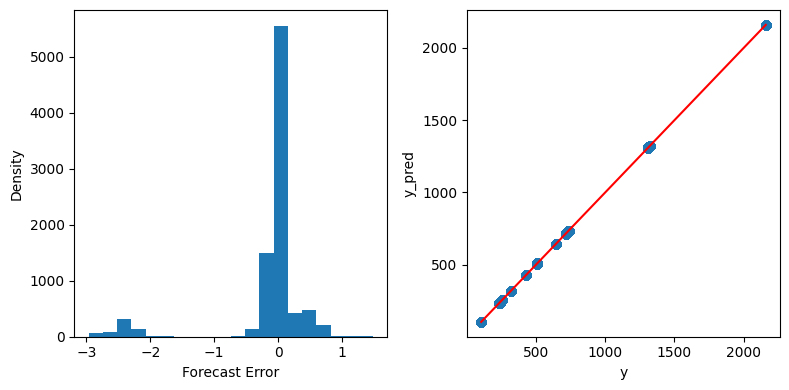

In [32]:
plot_model_performance(results2)

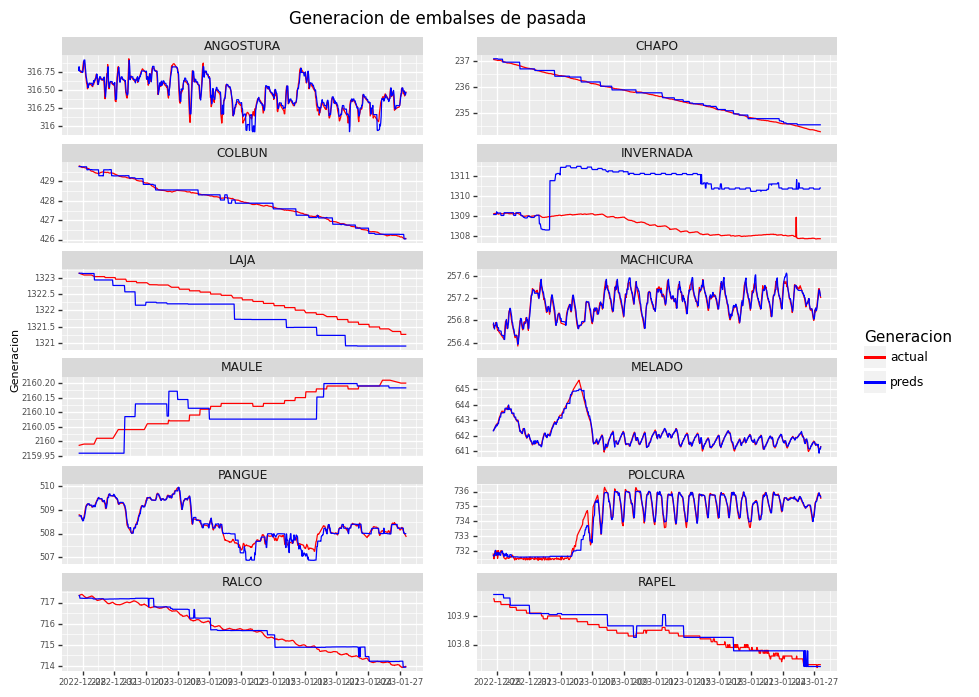

<ggplot: (8770003654098)>

In [33]:
plot_forecast(results2)

In [34]:
# Evaluation metrics
give_me_metrics(results2)

,MAE,MSE,RMSE,R2
nombre_embalse,,,,
ANGOSTURA,0.044526,0.004465,0.066823,0.898977
CHAPO,0.058557,0.005942,0.077086,0.990700
COLBUN,0.079340,0.008992,0.094827,0.991625
INVERNADA,2.024080,4.878904,2.208824,-21.311937
LAJA,0.456946,0.243358,0.493314,0.176327
MACHICURA,0.046834,0.003359,0.057954,0.946060
MAULE,0.044597,0.002754,0.052475,0.348441
MELADO,0.080575,0.013530,0.116317,0.983816
PANGUE,0.115850,0.033277,0.182421,0.933196


## XGBoost

In [35]:
model3 = xgb.XGBRegressor(random_state = 42)
model3.fit(X_train_prep, y_train_t)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [36]:
preds3 = model3.predict(X_test_prep)

In [37]:
results3 = pd.DataFrame(X_test_t.copy(), columns=X_test_t.columns)
results3["preds"] = preds3
results3["actual"] = y_test_t["value_corrected"].values
results3 = results3.reset_index()
results3 = results3[["timestamp","nombre_embalse","preds", "actual"]]
results3["preds"] = results3["preds"].clip(0)
results3["error"] = results3["actual"] - results3["preds"]
results3

,timestamp,nombre_embalse,preds,actual,error
0,2022-12-27 15:00:00+00:00,ANGOSTURA,316.807159,316.81,0.002841
1,2022-12-27 16:00:00+00:00,ANGOSTURA,316.798889,316.79,-0.008889
2,2022-12-27 17:00:00+00:00,ANGOSTURA,316.762909,316.78,0.017091
3,2022-12-27 18:00:00+00:00,ANGOSTURA,316.779510,316.78,0.000490
4,2022-12-27 19:00:00+00:00,ANGOSTURA,316.779663,316.76,-0.019663
...,...,...,...,...,...
8935,2023-01-27 11:00:00+00:00,RAPEL,103.737122,103.73,-0.007122
8936,2023-01-27 12:00:00+00:00,RAPEL,103.737122,103.73,-0.007122
8937,2023-01-27 13:00:00+00:00,RAPEL,103.737923,103.73,-0.007923
8938,2023-01-27 14:00:00+00:00,RAPEL,103.738205,103.73,-0.008205


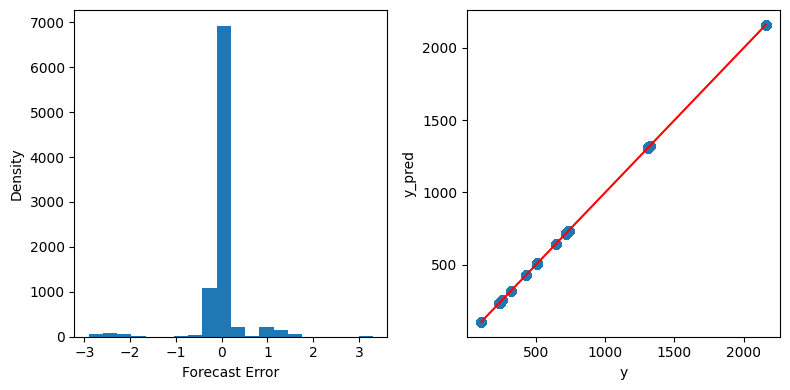

In [38]:
plot_model_performance(results3)

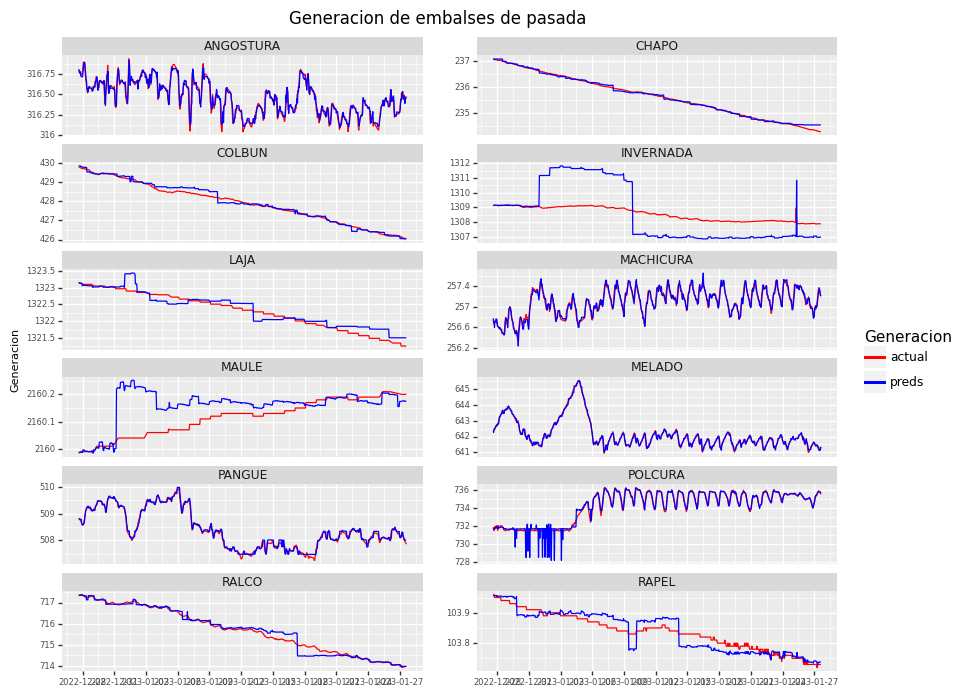

<ggplot: (8769996389130)>

In [39]:
plot_forecast(results3)

In [40]:
give_me_metrics(results3)

,MAE,MSE,RMSE,R2
nombre_embalse,,,,
ANGOSTURA,0.034099,0.002325,0.048214,0.947410
CHAPO,0.039580,0.003431,0.058576,0.994630
COLBUN,0.097848,0.018455,0.135848,0.982811
INVERNADA,1.373692,2.504114,1.582439,-10.451678
LAJA,0.138454,0.032062,0.179059,0.891482
MACHICURA,0.043172,0.002993,0.054709,0.951932
MAULE,0.051928,0.005761,0.075899,-0.363061
MELADO,0.065767,0.007298,0.085430,0.991270
PANGUE,0.054080,0.005015,0.070816,0.989933


## Linear model: Elastic Net

In [41]:
model4 = ElasticNet(alpha = 0.5, l1_ratio= 1)
model4.fit(X_train_prep, y_train_t)

ElasticNet(alpha=0.5, l1_ratio=1)

In [42]:
preds4 = model4.predict(X_test_prep)

In [43]:
results4 = pd.DataFrame(X_test_t.copy(), columns=X_test_t.columns)
results4["preds"] = preds4
results4["actual"] = y_test_t["value_corrected"].values
results4 = results4.reset_index()
results4 = results4[["timestamp","nombre_embalse","preds", "actual"]]
results4["preds"] = results4["preds"].clip(0)
results4["error"] = results4["actual"] - results4["preds"]
results4

,timestamp,nombre_embalse,preds,actual,error
0,2022-12-27 15:00:00+00:00,ANGOSTURA,317.159696,316.81,-0.349696
1,2022-12-27 16:00:00+00:00,ANGOSTURA,317.169688,316.79,-0.379688
2,2022-12-27 17:00:00+00:00,ANGOSTURA,317.149705,316.78,-0.369705
3,2022-12-27 18:00:00+00:00,ANGOSTURA,317.139714,316.78,-0.359714
4,2022-12-27 19:00:00+00:00,ANGOSTURA,317.139714,316.76,-0.379714
...,...,...,...,...,...
8935,2023-01-27 11:00:00+00:00,RAPEL,104.277068,103.73,-0.547068
8936,2023-01-27 12:00:00+00:00,RAPEL,104.277068,103.73,-0.547068
8937,2023-01-27 13:00:00+00:00,RAPEL,104.277068,103.73,-0.547068
8938,2023-01-27 14:00:00+00:00,RAPEL,104.277068,103.73,-0.547068


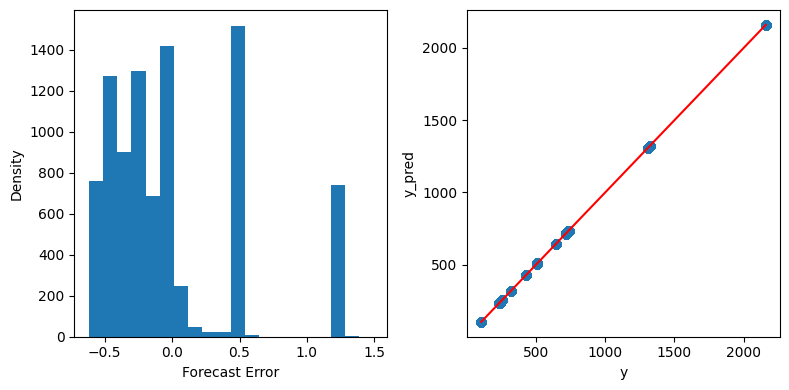

In [44]:
plot_model_performance(results4)

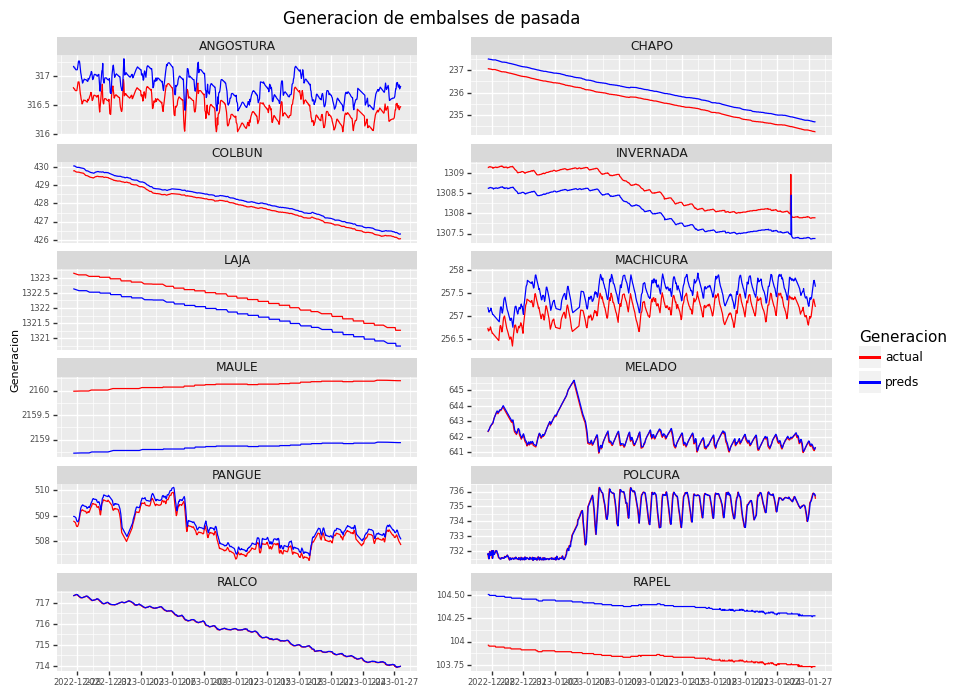

<ggplot: (8769997499371)>

In [45]:
plot_forecast(results4)

In [46]:
give_me_metrics(results4)

,MAE,MSE,RMSE,R2
nombre_embalse,,,,
ANGOSTURA,0.360425,0.132503,0.364010,-1.997742
CHAPO,0.434855,0.189123,0.434883,0.704010
COLBUN,0.267017,0.071368,0.267147,0.933528
INVERNADA,0.512138,0.263643,0.513462,-0.205679
LAJA,0.521989,0.272581,0.522093,0.077420
MACHICURA,0.411631,0.172200,0.414970,-1.765500
MAULE,1.261588,1.591607,1.261589,-375.601800
MELADO,0.081412,0.013770,0.117345,0.983529
PANGUE,0.192464,0.039699,0.199246,0.920304
